<a href="https://colab.research.google.com/github/chenwh0/Natural-Language-Processing-work/blob/main/module6/ProbabilitiesAndLLMTokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Transformer LLM Internals and Token-Level Analysis**

This lab analyzed tokenization, probability distributions, attention mechanisms, and generation strategies. Esentially how LLMs processed and generated text at the token level, examining the mathematical foundations (probabilities) behind their predictions.

# *Sources/References*

* [From Logits to Probabilities: Understanding Softmax in Neural Networks
](https://medium.com/ai-enthusiast/from-logits-to-probabilities-understanding-softmax-in-neural-networks-3ebea2e95cfe)
* [Why Use Softmax as Opposed to Simple Normalization
](https://www.baeldung.com/cs/softmax-vs-simple-normalization-neural-nets)


# *Installs & Imports*

In [ ]:
!pip install tqdm -q

In [ ]:
# Data preprocessing libraries
import pandas

# LLM libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import trange
import torch
import torch.nn.functional as F

# Word-level tokenizer library
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualize data
import matplotlib.pyplot as pyplot

# **1. Model Architecture Analysis and Setup**

`print(model_name)` displays the key components of the model (in this case, *TinyLlama*) & its dimensions (length of numerical vector representing each token).

1. Inputs passed through embedding layer `Embedding(32000, 2048)`
2. Pass through 22 `LlamaDecoderLayer`s. Each `LlamaDecoderLayer` contains the following:

>> a. Self-attention mechanism - `LlamaAttention()` contains `Linear()` layers to project input into key, query, value, and output ***2048-dimensional vectors*** for the self-attention mechanism.

>> b. Multi-Layer Perceptron (MLP) - `LlamaMLP()` contains `Linear()` layers to project input into Up, Down, and Gate paths. Gate output are sent to `SiLU()`, a Sigmoid Linear Unit activation. The result is multiplied by Up output and projected back to 2048-dimensional vector by the Down output.

>>c. Normalization of input - `LlamaRMSNorm()` applies Root Mean Square Normalization to every 2048-dimensional vector. An epsilon value of 1e-05 is used to avoid division by zero errors.

>>d. Normalization of output of self-attention - `LlamaRMSNorm()` applies Root Mean Square Normalization to every 2048-dimensional vector. An epsilon value of 1e-05 is used to avoid division by zero errors.

3. Add positional encodings - `LlamaRotaryEmbedding()` add positional information attention mechanisms without using absolute positional encodings.
4. Langugage Modeling Head - Uses `Linear()` to map 2048-dimensional vectors back to 32000 vocabularies for output.

## Vocabulary size vs Hidden dimensions
`Embedding(32000, 2048)` layer shows that TinyLlama has 32000 vocabulary size and uses 2048-dimensional vectors to represent each token in its hidden layers. The hidden dimensions are ~15x smaller than vocabulary size for efficiency.

## Why do transformer models use layer normalization instead of batch normalization?
For sequential data with variable-length sequences (such as natural language text), layer normalization is individualized to the sample, producing more consistent normalization results. In batch normalization, varied lengths text samples would all be calculated within their batches, thus producing inconsistent normalization constants and instability during training


In [ ]:
class ModelLLM:
    def __init__(self, name):
        self.name = name # Replace with actual model ID from Hugging Face
        self.tokenizer = tinyLlama_tokenizer = AutoTokenizer.from_pretrained(name)
        self.model = AutoModelForCausalLM.from_pretrained(name)

    def generate(self, prompt, cache=False, temperature=1): # Generate output from 1 string (promnpt)
        tokenized_inputs = self.tokenizer(prompt, return_tensors="pt")
        token_ids = self.model.generate(**tokenized_inputs, max_new_tokens=100, use_cache=cache, do_sample=True, temperature=temperature)
        decoded_tokens = self.tokenizer.decode(token_ids[0], skip_special_tokens=True)
        return decoded_tokens

    def multi_generate(self, prompts, cache=False, temperature=1): # Generate outputs from list of strings (prompts)
        outputs = []
        for i in trange(len(prompts)):
            decoded_tokens = self.generate(prompts[i], cache=cache, temperature=temperature)
            outputs.append(decoded_tokens)
        return outputs

    def tokenize(self, prompt): # Tokenize 1 string (prompt)
        token_ids = self.tokenizer.encode(prompt)
        decoded_tokens = self.tokenizer.convert_ids_to_tokens(token_ids)
        return {"input": prompt, "token_ids": token_ids, "decoded_tokens": decoded_tokens}

    def multi_tokenize(self, prompts): # Tokenize list of strings (prompts)
        rows = []
        for i in range(len(prompts)):
            row = self.tokenize(prompts[i])
            print("Input text:", prompts[i])
            print("Token ids:", row["token_ids"])
            print("Decoded tokens:", row["decoded_tokens"])
            row["prompt_num"] = i
            rows.append(row)
        return pandas.DataFrame.from_dict(rows, orient="columns")

tinyLlama = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tinyLlama_model = ModelLLM(tinyLlama)
print(tinyLlama_model.model)

# **2. Tokenization and Vocabulary Investigation**

  ## Handling out-of-vocabulary words, numbers, and special characters
Prompt 6 contained chinese natural language text as well as the number 10. TinyLlama's tokenizer converted special tokens such as chinese words into their byte representations. TinyLlama's tokenizer breaks 10 down into 2 tokens '1' and '0'.

  ## Capitalization affects tokenization
Prompt 5 contained "the" and "The" in natural langauage prompt. TinyLlama's tokenizer had different representations for both 'the's because both forms of capitalization have different meanings.

  ## Context affects tokenization
Prompt 5 contained "states" and "States" in natural language prompt. The first mention "states" referred to nations. The second "States" referred to the philisophical and social entity State, as in the the executive-body of a current governing political system. Both of these "states" words were assigned different token ids, meaning the tokenizer was able to understand their differences based on contexts

  ## Comparative Analysis
In comparison, a simple word-level tokenizer such as *TF-IDF* tokenizer would...
* Tokenize special characters such as non-english natural language text as 1 token and it would fail to detect the numerical characters within the non-english natural language text.
* Tokenize words of polysemy with the same token ids.

In [ ]:
prompts = [
    "New methodologies for dynamically incorporating automatic feature extraction for content-based database management and retrieval?<|assistant|>",
    "Tell me more about GeoIRIS.<|assistant|>",
    "'If I get one more L I'm gonna yeet my controller out a window no cap'. What does this mean?<|assistant|>",
    "One will need a 🖥️ first to make a 🌏 application, right?<|assistant|>",
    "Why order each bin, i ∈ [1, F], from W+y and W−y, such that S[i] = max {W +yi , W −yi } and S[i + F] = min {W +yi , W −yi }?<|assistant|>",
    """Mass worker protests are erupting across the states in South Asia, Europe, and South America as wealth inequality deepens.
    With police deploying tear gas and foam projectiles, workers are starting to ask: What role does The states really play in a capitalist society?<|assistant|>""",
    "中國在人工智慧領域有哪10方面已經超越美國?<|assistant|>"
]

In [ ]:
tinyLlama_tokens_dataframe = tinyLlama_model.multi_tokenize(prompts)
display(tinyLlama_tokens_dataframe)

Input text: New methodologies for dynamically incorporating automatic feature extraction for content-based database management and retrieval?<|assistant|>
Token ids: [1, 1570, 1158, 11763, 363, 11200, 11039, 1218, 18428, 4682, 4805, 428, 363, 2793, 29899, 6707, 2566, 10643, 322, 5663, 16837, 29973, 29966, 29989, 465, 22137, 29989, 29958]
Decoded tokens: ['<s>', '▁New', '▁method', 'ologies', '▁for', '▁dynamically', '▁incorpor', 'ating', '▁automatic', '▁feature', '▁extra', 'ction', '▁for', '▁content', '-', 'based', '▁database', '▁management', '▁and', '▁retr', 'ieval', '?', '<', '|', 'ass', 'istant', '|', '>']
Input text: Tell me more about GeoIRIS.<|assistant|>
Token ids: [1, 24948, 592, 901, 1048, 1879, 29877, 8193, 3235, 19423, 29989, 465, 22137, 29989, 29958]
Decoded tokens: ['<s>', '▁Tell', '▁me', '▁more', '▁about', '▁Ge', 'o', 'IR', 'IS', '.<', '|', 'ass', 'istant', '|', '>']
Input text: 'If I get one more L I'm gonna yeet my controller out a window no cap'. What does this mean?<|as

,input,token_ids,decoded_tokens,prompt_num
0,New methodologies for dynamically incorporatin...,"[1, 1570, 1158, 11763, 363, 11200, 11039, 1218...","[<s>, ▁New, ▁method, ologies, ▁for, ▁dynamical...",0
1,Tell me more about GeoIRIS.<|assistant|>,"[1, 24948, 592, 901, 1048, 1879, 29877, 8193, ...","[<s>, ▁Tell, ▁me, ▁more, ▁about, ▁Ge, o, IR, I...",1
2,'If I get one more L I'm gonna yeet my control...,"[1, 525, 3644, 306, 679, 697, 901, 365, 306, 2...","[<s>, ▁', If, ▁I, ▁get, ▁one, ▁more, ▁L, ▁I, '...",2
3,One will need a 🖥️ first to make a 🌏 applicati...,"[1, 3118, 674, 817, 263, 29871, 243, 162, 153,...","[<s>, ▁One, ▁will, ▁need, ▁a, ▁, <0xF0>, <0x9F...",3
4,"Why order each bin, i ∈ [1, F], from W+y and W...","[1, 3750, 1797, 1269, 9016, 29892, 474, 29871,...","[<s>, ▁Why, ▁order, ▁each, ▁bin, ,, ▁i, ▁, ∈, ...",4
5,Mass worker protests are erupting across the s...,"[1, 7360, 15645, 10021, 29879, 526, 604, 21245...","[<s>, ▁Mass, ▁worker, ▁protest, s, ▁are, ▁er, ...",5
6,中國在人工智慧領域有哪10方面已經超越美國?<|assistant|>,"[1, 29871, 30275, 30915, 30505, 30313, 31041, ...","[<s>, ▁, 中, 國, 在, 人, 工, 智, <0xE6>, <0x85>, <0x...",6


In [ ]:
def compare_token_and_decoded(dataframe, prompt_num):
    token_ids = dataframe["token_ids"][prompt_num]
    decoded_tokens = dataframe["decoded_tokens"][prompt_num]
    token_count = len(decoded_tokens)
    print(f"\n\nFrom prompt {prompt_num}:")
    dataframe = pandas.DataFrame({"token_id": token_ids, "decoded_token": decoded_tokens})
    display(dataframe.sample(4))
    return dataframe

special_token_comparison = compare_token_and_decoded(tinyLlama_tokens_dataframe, 6)
polysemy_comparison = compare_token_and_decoded(tinyLlama_tokens_dataframe, 5)



From prompt 6:


,token_id,decoded_token
33,29989,|
4,30505,在
27,31480,超
0,1,<s>




From prompt 5:


,token_id,decoded_token
18,322,▁and
3,10021,▁protest
57,12459,▁society
5,526,▁are


In [ ]:
print("Special character cases in prompt 6...")
display(special_token_comparison[special_token_comparison["decoded_token"].str.contains("1")])
display(special_token_comparison[special_token_comparison["decoded_token"].str.contains("0")])

Special character cases in prompt 6...


,token_id,decoded_token
21,29896,1


,token_id,decoded_token
8,233,<0xE6>
9,136,<0x85>
10,170,<0xA7>
11,236,<0xE9>
12,163,<0xA0>
13,155,<0x98>
14,232,<0xE5>
15,162,<0x9F>
16,162,<0x9F>
18,232,<0xE5>


In [ ]:
print("Polysemy cases in prompt 5...")
display(polysemy_comparison[polysemy_comparison["decoded_token"].str.lower().str.contains("the")])
display(polysemy_comparison[polysemy_comparison["decoded_token"].str.lower().str.contains("states")])

Polysemy cases in prompt 5...


,token_id,decoded_token
10,278,▁the
49,450,▁The


,token_id,decoded_token
11,5922,▁states
50,5922,▁states


In [ ]:
# Compare to word-level tokenizer
def word_level_tokenizer(prompts, prompt_num):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(prompts)
    tokens_by_word = vectorizer.build_tokenizer()(prompts[prompt_num].lower())
    token_ids = [vectorizer.vocabulary_[token] for token in tokens_by_word]

    # Decode: reconstruct text from vector
    nonzero_indices = X.nonzero()[1] # Get indices of non-zero TF-IDF values
    decoded_tokens = [vectorizer.get_feature_names_out()[i] for i in token_ids]
    TFidf_dataframe = pandas.DataFrame({"token_id": token_ids, "decoded_token": decoded_tokens})
    return TFidf_dataframe

TFidf_dataframe5 = word_level_tokenizer(prompts, 5)
TFidf_dataframe6 = word_level_tokenizer(prompts, 6)


display(TFidf_dataframe6[TFidf_dataframe6["decoded_token"].str.lower().str.contains("10")])
print("\n\n")
display(TFidf_dataframe5[TFidf_dataframe5["decoded_token"].str.lower().str.contains("the")])
display(TFidf_dataframe5[TFidf_dataframe5["decoded_token"].str.lower().str.contains("states")])

,token_id,decoded_token
0,120,中國在人工智慧領域有哪10方面已經超越美國


,token_id,decoded_token
6,105,the
35,105,the


,token_id,decoded_token
7,99,states
36,99,states


# **3. Probability Distribution and Next-Token Prediction**

a. Tested how different temperatures (0.1, 1.0, 2.0) affected probability distribution?

b. Visualize how probability distributions change with different prompts and temperature settings.


**softmax()**: The model's outputted logits have values that can range between negative and positive infinity. Using `softmax()` will convert these values to probabilites that can sum to 1. This allows for more easily interpretable outputs that can be fed directly into loss functions like cross-entropy loss. Other normalization methods such as simple normalization doesn't allow for negative logits or compatability with the cross-entropy loss function


**temperature**: Probabilities are divided by temperature before applying softmax. Temperature is a numerical value that introduces randomness to model by "sharpening"/"softening" its softmax distribution. The probabilities can vary starkly (temperatuer > 1) or have less differenecs between them (temperature < 1).
* temperature = 0. Equivalent to greedy decoding
* temperature < 1. More focused, predictable outputs
* temperature = 1. Original probability distribution
* temperature > 1. More random & creative outputs.

**output probabilities**: The closer an output probability value is to 1.0, the higher confidence the model has that the probability's corresponding token is the correct prediciton for the next token.

In [ ]:
def top_k_sampling(prompt, model, temperature=1, k=10):
    torch_token_ids = model.tokenizer(simple_prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model.model(**torch_token_ids)

    # Logits: (batch_size, sequence_length, vocab_size)
    logits = outputs.logits
    print("Logits:", logits)

    # Last token’s logits (this is final output)
    last_token_logits = logits[0, -1, :]   # shape: [vocab_size]

    if temperature != 0: # For greedy-decoding where temperature = 0, skip this step
        last_token_logits = last_token_logits / temperature # temperature=sharpen (temperature > 1) or blur (temperature < 1) the difference between probabilities

    # Convert to probabilities
    probabilities = F.softmax(last_token_logits, dim=-1)
    print("\nProbabilities:", probabilities)

    topk_probabilities, topk_indices = torch.topk(probabilities, k) # k=number of top predictions to retrieve

    # Convert token IDs to strings
    topk_tokens = [model.tokenizer.decode([index]) for index in topk_indices]

    print(f"\nTop {k} most probable next tokens when temperature={temperature}:")
    next_token_probabilities = dict(zip(topk_tokens, topk_probabilities))
    for token, probability in next_token_probabilities.items():
        print(f"{token}: {probability:4f}")
    return next_token_probabilities


In [ ]:
simple_prompt = "The capital of France is"

In [ ]:
next_token_probabilities01 = top_k_sampling(simple_prompt, tinyLlama_model, temperature=0.1, k=k) # Let temperature=0.1

Logits: tensor([[[ -4.6822,   0.9866,   4.5126,  ...,  -5.2010,  -2.1646,  -4.2286],
         [-10.8859, -10.9407,   1.5036,  ...,  -6.6481,  -8.2838,  -5.6943],
         [ -9.5158,  -9.8572,   4.6451,  ...,  -3.5518,  -7.5003,  -6.1203],
         [ -9.7580,  -9.8462,   3.0701,  ...,  -5.0384,  -7.4027,  -6.0314],
         [ -9.7188,  -9.8224,   8.8114,  ...,  -5.7648,  -9.6631,  -7.9894],
         [ -7.3856,  -6.9689,   8.2872,  ...,  -4.2601,  -8.7164,  -6.5213]]])

Probabilities: tensor([0.0000e+00, 0.0000e+00, 7.0061e-23,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

Top 10 most probable next tokens when temperature=0.1:
Paris: 0.999986
located: 0.000014
:: 0.000000
the: 0.000000
?: 0.000000
,: 0.000000
.: 0.000000

: 0.000000
_: 0.000000
a: 0.000000


In [ ]:
next_token_probabilities2 = top_k_sampling(simple_prompt, tinyLlama_model, temperature=1, k=10) # Let temperature=1

Logits: tensor([[[ -4.6822,   0.9866,   4.5126,  ...,  -5.2010,  -2.1646,  -4.2286],
         [-10.8859, -10.9407,   1.5036,  ...,  -6.6481,  -8.2838,  -5.6943],
         [ -9.5158,  -9.8572,   4.6451,  ...,  -3.5518,  -7.5003,  -6.1203],
         [ -9.7580,  -9.8462,   3.0701,  ...,  -5.0384,  -7.4027,  -6.0314],
         [ -9.7188,  -9.8224,   8.8114,  ...,  -5.7648,  -9.6631,  -7.9894],
         [ -7.3856,  -6.9689,   8.2872,  ...,  -4.2601,  -8.7164,  -6.5213]]])

Probabilities: tensor([4.8373e-10, 7.3381e-10, 3.0991e-03,  ..., 1.1015e-08, 1.2783e-10,
        1.1481e-09])

Top 10 most probable next tokens when temperature=1:
Paris: 0.508956
located: 0.166096
:: 0.021754
the: 0.021566
?: 0.020989
,: 0.016506
.: 0.014429

: 0.012139
_: 0.011896
a: 0.011815


In [ ]:
next_token_probabilities2 = top_k_sampling(simple_prompt, tinyLlama_model, temperature=2, k=k) # Let temperature=2

Logits: tensor([[[ -4.6822,   0.9866,   4.5126,  ...,  -5.2010,  -2.1646,  -4.2286],
         [-10.8859, -10.9407,   1.5036,  ...,  -6.6481,  -8.2838,  -5.6943],
         [ -9.5158,  -9.8572,   4.6451,  ...,  -3.5518,  -7.5003,  -6.1203],
         [ -9.7580,  -9.8462,   3.0701,  ...,  -5.0384,  -7.4027,  -6.0314],
         [ -9.7188,  -9.8224,   8.8114,  ...,  -5.7648,  -9.6631,  -7.9894],
         [ -7.3856,  -6.9689,   8.2872,  ...,  -4.2601,  -8.7164,  -6.5213]]])

Probabilities: tensor([1.1373e-06, 1.4008e-06, 2.8787e-03,  ..., 5.4273e-06, 5.8466e-07,
        1.7522e-06])

Top 10 most probable next tokens when temperature=2:
Paris: 0.036892
located: 0.021075
:: 0.007627
the: 0.007594
?: 0.007492
,: 0.006644
.: 0.006212

: 0.005697
_: 0.005640
a: 0.005621


In [ ]:
def plot_bar_chart(token_probabilities, temperature):
    tokens = list(token_probabilities.keys())
    probabilities = list(token_probabilities.values())

    pyplot.figure(figsize=(8, 6)) # Optional: Adjust figure size
    pyplot.bar(range(len(tokens)), probabilities, color='skyblue') # Optional: Add color

    pyplot.xticks(range(len(tokens)), tokens, rotation=45, ha='right') # Rotate labels for better fit
    pyplot.xlabel("Next token")
    pyplot.ylabel("Probability")
    pyplot.title(f"Probability distribution for next token when temp={temperature}")
    pyplot.tight_layout() # Adjust layout to prevent labels from overlapping
    pyplot.show()

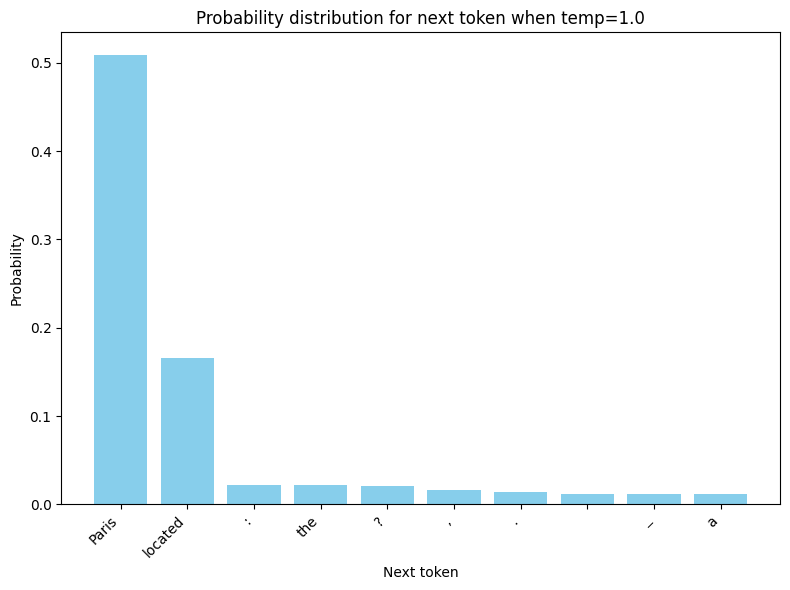

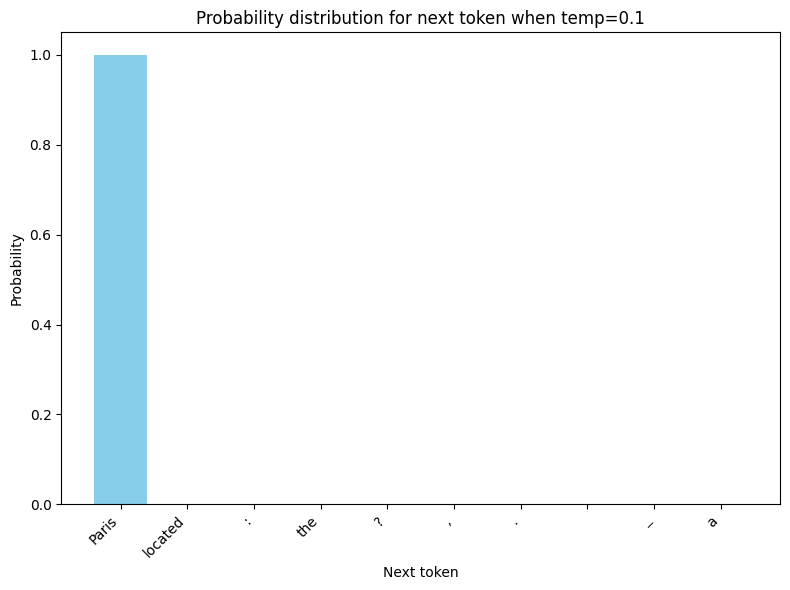

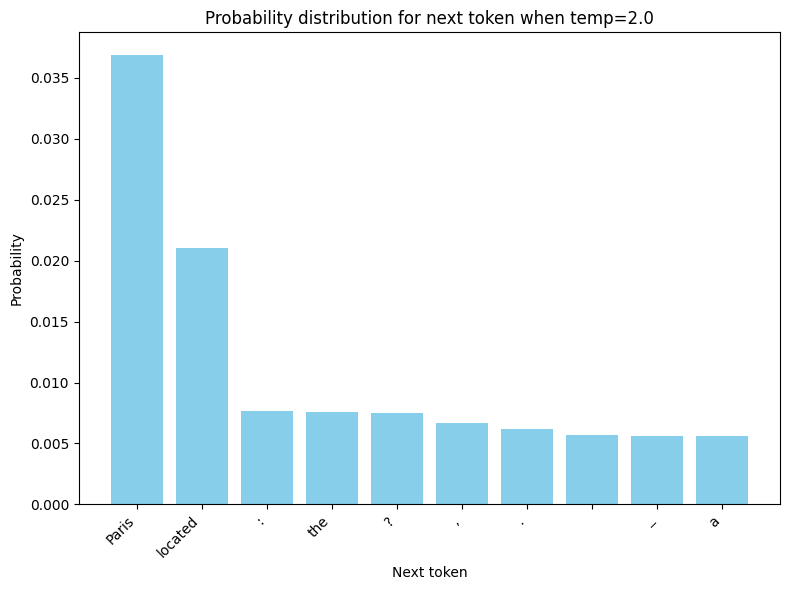

In [ ]:
plot_bar_chart(next_token_probabilities1, 1.0)
plot_bar_chart(next_token_probabilities01, 0.1)
plot_bar_chart(next_token_probabilities2, 2.0)

# **4. Generation Strategies and Computational Efficiency**

- **Performance Analysis:**
  - Implement and time text generation with and without key-value caching.
    - Compare greedy decoding, top-k sampling, and nucleus (top-p) sampling on the same prompt.

**Greedy decoding**: Temperature = 0, meaning always choose highest probability token. The output is not diverse and may not always be the best but it is deterministic (predictable and replicatable).

**Top-k sampling**: Only consider top k most probable tokens. Ex: Top-5 sampling only select from 5 most likely tokens. This prevents the selection of very unlikely next tokens while still introducing more diversity than greedy decoding. Does not always gurantee optimal-quality outputs.

**Top-p sampling**: Sample from smallest set of tokens whose cumulative probability >= some probability.This allows for dynamic adjustments based on model confidence. Leading to quality outputs that consider the length of the confidence of the model when introducing diversity/less probable next tokens. Ex: p=0.9, may include 3 tokens when model is confident, 20 when uncertain

## Speedup using KV-caching
KV-caching stores Keys & Values for all previously processed tokens from attention mechanism. Using KV-caching, all previous Key and Value values calculated from previous executions of attention mechanism (for previously processed tokens) is cached. This causes a dramatic speedup because the latency from recalculating Key and Value values for every new generation are eliminated.

## Attention vs sequence length
The longer the sequence length, the higher amount of computational complexity for attention since there are increasing number of relationships and contexts that model must keep track of.

## Tradeoff between caching vs recomputation
More memory is required for more caching. If the task of previous token generation is offloaded to recomputation of Key and Value values, then less caching would be needed, thus less memory required (at the expense of slower generation time).

In [ ]:
%%timeit -n 1
outputs_using_cache = tinyLlama_model.generate(prompts[6], cache=True, temperature=0.1)

46.3 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -n 1
outputs_no_cache = tinyLlama_model.generate(prompts[6], cache=False, temperature=0.1) # This took over 48 minutes so I stopped it, but it essentially takes O(N^2) time compared to KV-caching which takes O(N) time

KeyboardInterrupt: 

Logits: tensor([[[ -4.6822,   0.9866,   4.5126,  ...,  -5.2010,  -2.1646,  -4.2286],
         [-10.8859, -10.9407,   1.5036,  ...,  -6.6481,  -8.2838,  -5.6943],
         [ -9.5158,  -9.8572,   4.6451,  ...,  -3.5518,  -7.5003,  -6.1203],
         [ -9.7580,  -9.8462,   3.0701,  ...,  -5.0384,  -7.4027,  -6.0314],
         [ -9.7188,  -9.8224,   8.8114,  ...,  -5.7648,  -9.6631,  -7.9894],
         [ -7.3856,  -6.9689,   8.2872,  ...,  -4.2601,  -8.7164,  -6.5213]]])

Probabilities: tensor([4.8373e-10, 7.3381e-10, 3.0991e-03,  ..., 1.1015e-08, 1.2783e-10,
        1.1481e-09])

Top 5 most probable next tokens when temperature=0:
Paris: 0.508956
located: 0.166096
:: 0.021754
the: 0.021566
?: 0.020989


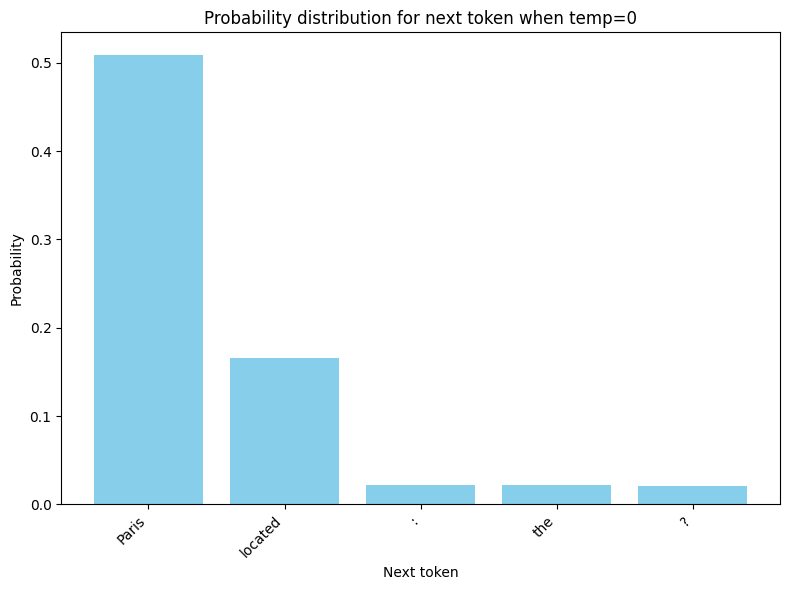

Logits: tensor([[[ -4.6822,   0.9866,   4.5126,  ...,  -5.2010,  -2.1646,  -4.2286],
         [-10.8859, -10.9407,   1.5036,  ...,  -6.6481,  -8.2838,  -5.6943],
         [ -9.5158,  -9.8572,   4.6451,  ...,  -3.5518,  -7.5003,  -6.1203],
         [ -9.7580,  -9.8462,   3.0701,  ...,  -5.0384,  -7.4027,  -6.0314],
         [ -9.7188,  -9.8224,   8.8114,  ...,  -5.7648,  -9.6631,  -7.9894],
         [ -7.3856,  -6.9689,   8.2872,  ...,  -4.2601,  -8.7164,  -6.5213]]])

Probabilities: tensor([1.1373e-06, 1.4008e-06, 2.8787e-03,  ..., 5.4273e-06, 5.8466e-07,
        1.7522e-06])

Top 5 most probable next tokens when temperature=2:
Paris: 0.036892
located: 0.021075
:: 0.007627
the: 0.007594
?: 0.007492


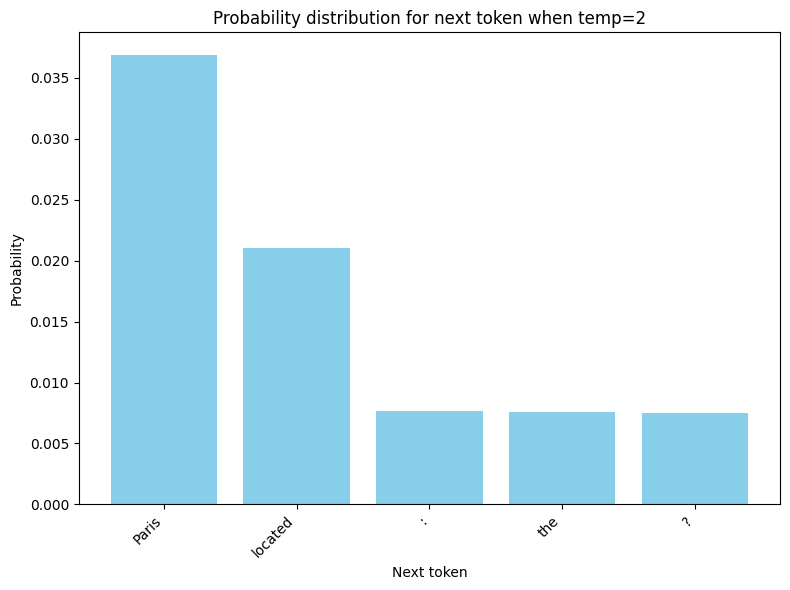

In [ ]:
greedy_decoding_probabilities = top_k_sampling(simple_prompt, tinyLlama_model, temperature=0, k=5)  # Greedy-decoding
plot_bar_chart(greedy_decoding_probabilities, 0)

top_k_sampling_output = top_k_sampling(simple_prompt, tinyLlama_model, temperature=2, k=5) # Top k sampling
plot_bar_chart(top_k_sampling_output, 2)


In [ ]:
top_p_sampling_output = tinyLlama_model.generate(simple_prompt, cache=True, top_p=0.9)
plot_bar_chart(top_p_sampling_output, 1)

In [ ]:
# Top p sampling
tokenized_inputs = tinyLlama_model.tokenizer(simple_prompt+"<|assistant|>", return_tensors="pt").to(tinyLlama_model.model.device) # Tokenize the input prompt

# Generate text using nucleus (top-p) sampling
token_ids = tinyLlama_model.model.generate(
    **tokenized_inputs,
    max_new_tokens=10,
    use_cache=True,
    do_sample=True,
    top_p=0.9              # nucleus/top p sampling
)

# Decode back to text
decoded_tokens = tinyLlama_model.tokenizer.decode(token_ids[0], skip_special_tokens=True)
print(decoded_tokens)

The capital of France is<|assistant|>
The capital of France is Paris.


# **5. Model Behavior and Limitations Analysis**

## Trick/Ambiguous prompts
TinyLlama was provided with a trick prompt involving incorrect math. The model was uncertain and could not immidiately predict the answer to the math problem, therefore, it tried to use chain of reasoning to step through the problem. Unfortunately, for this generation it confused 5^3 with 5*3 therefore it started on the wrong reasoning.

TinyLlama was provided with an ambiguous prompt involving very open-ended prompt (asking about the weather). The model may have been uncertain about the location of the weather the prompt was referring to, therefore it hallucinated/extracted from training data and assumed that the prompt was referring to Sydney.

## Unusal tokenization affects model performance
From this experiment, model performance for prompt 5 (in Chinese natural text) likely because of the complex relationships that the model needed to balance when some of the tokens are tokenized as valid Chinese characters while others were tokenized as their byte-level representations.

## LLMs and human language
TinyLlama is a tiny model, from a surface-level it doesn't match a human's ability to "understand" language in comparison to the larger and more optimal GPT, Llama, BERT-based etc. models today. The first 2 experiments below shows that the model lacks understanding of contexts in some cases (relying on sophisticated pattern matching for the ambiguous question experiment)

However, there are some similarities with how humans understand language. To react to external stimulus (such as reading), light signals are registered and transform to electrical signals that the human brain can understand. These electric signals are propelled thouroughout the different neurons in the brain for complex processing of the meaning of the shape of the characters and how each one relates to one another in our understanding of the language. Similarly, modern LLMs are powered by taking in inputs, converting them to numerical representations for easier machine understanding, then the numerical representations are propelled through its numerous multi-layer perceptrons (MLP) for processing and calculations to generate a response.


Next-token prediction allows for prediction of "most-likely" next words, so model begin to form coherent full sentences then paragraphs based on its relation to the prompt and the "most-likely" answer. Some limitations are that billions of parameters are required to have the most optimal generative models, this makes memory expensive and local usage of these models on general-purpose computers near impossible.

In [ ]:
trick_question = "If 5 to the power of 2 = 30, what is 5 to the power of 3 = ?<|assistant|>"
trick_question_output = tinyLlama_model.generate(trick_question, cache=True)
print(trick_question_output)

If 5 to the power of 2 = 30, what is 5 to the power of 3 = ?<|assistant|>

To find 5 to the power of 3 (5 to the power of 3), we need to follow the method for finding powers of 2 using exponents:

- 5 raised to the power of 3 (5x3)
- 5 to the power of 3 = 5 * 3 ** 3 (5 * 3)
- 5 * 3 ** 3 = 5 * 9 (5 * 3


In [ ]:
ambiguous_question = "What is the weather like today?<|assistant|>"
ambiguous_question_output = tinyLlama_model.generate(ambiguous_question, cache=True)
print(ambiguous_question_output)

What is the weather like today?<|assistant|>
Yes, the weather today in Sydney is sunny and warm. It's expected to stay mostly dry and mostly warm, with a maximum temperature of 27°C and a minimum temperature of 21°C. Today's predicted wind direction is South Easterly at around 17 km/h, with an overall direction of South. It's forecasted that there could be a high chance of rain on Saturday.
